Code Modified From: https://youtu.be/PuZY9q-aKLw

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from preprocess import load_data, load_data_db

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback

In [2]:
data_set = load_data_db("datab.db") 

In [3]:
print(data_set.shape) 
item = "SPONGE"
data = data_set[data_set['item'] == item] 

print(data.shape)

(2029531, 8)
(1556, 8)


In [4]:
# item = "SPONGE"

# data_set = load_data()
# data = data_set[item]

# for i in range(0, len(data)):
#     if data["buy_volume"][i] == 0 and data["sell_volume"][i] == 0:
#         data = data.drop(i)

In [4]:
print(data.head())
print(data.shape) 

            date    item  sell_price  sell_volume  sell_moving_week  \
160   1707951651  SPONGE   42.406750      5747081           7480195   
1455  1707955250  SPONGE   42.487058      5769887           7532305   
2750  1707958851  SPONGE   42.736993      5831963           7580315   
4045  1707962450  SPONGE   42.411493      5720894           7620649   
5340  1707966050  SPONGE   42.315665      5657846           7683697   

      buy_price  buy_volume  buy_moving_week  
160   59.985276      332194           967014  
1455  65.142329      322401           976807  
2750  67.978409      312956           986083  
4045  67.700000      321901           987142  
5340  67.400000      330600           988292  
(1556, 8)


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['sell_price'].values.reshape(-1, 1))
scaled_data = scaled_data.flatten()
print(scaled_data.shape)

(1556,)


In [6]:
prediction_hours = 48
train_test_split = 0.8

len_train = int(len(scaled_data) * train_test_split)  

x_train = []
y_train = []

x_test = [] 
y_test = []

for i in range(prediction_hours, len_train):
    x_train.append(scaled_data[i - prediction_hours:i])
    y_train.append(scaled_data[i]) 

for i in range(len_train, len(scaled_data)):
    x_test.append(scaled_data[i - prediction_hours:i])
    y_test.append(scaled_data[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape) 
print(y_test.shape)


(1196, 48)
(1196,)
(312, 48)
(312,)


In [7]:
class DetectOverfittingCallback(Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

In [8]:
model = Sequential()

model.add(LSTM(units=40, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=40))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2024-04-22 13:07:54.280383: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-22 13:07:54.280424: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-22 13:07:54.280435: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-22 13:07:54.280466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-22 13:07:54.280480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 48, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 48, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 40)            12960     
                                                                 
 dropout_2 (Dropout)         (None, 48, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                1

In [10]:
history = model.fit(x_train, y_train, epochs=1, batch_size=32, verbose=1, validation_data=(x_test, y_test), callbacks=[DetectOverfittingCallback(threshold=5)])

2024-04-22 13:07:56.190356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 6s 76ms/step - loss: 0.0892 - val_loss: 0.0079


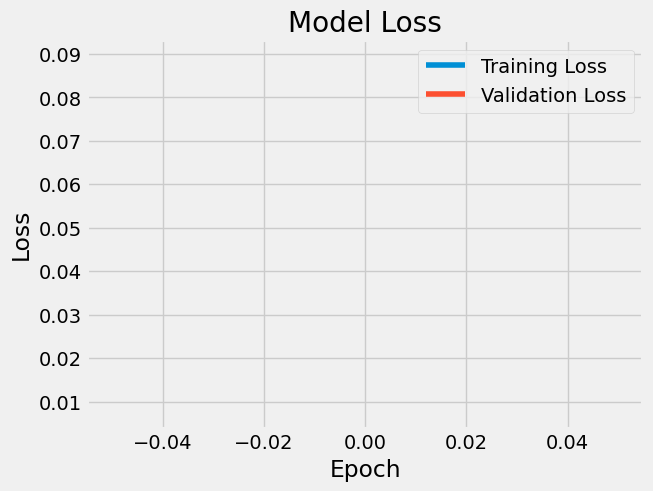

In [11]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted) 

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 [==============================] - 1s 9ms/step


In [13]:
print(predicted.shape)
print(y_test.shape)

(312, 1)
(312, 1)


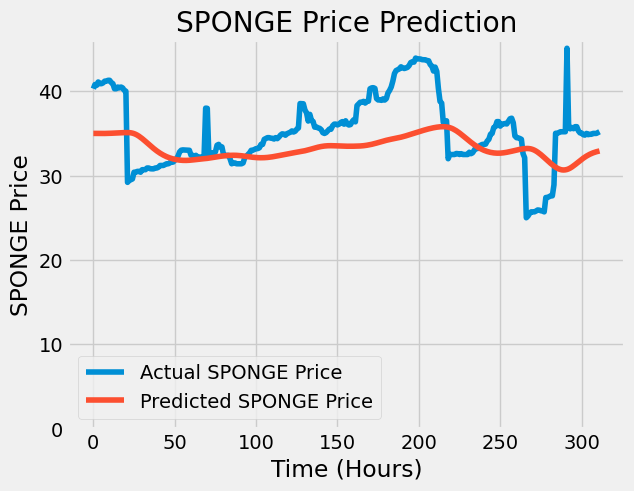

In [14]:
plt.style.use('fivethirtyeight')
plt.plot(y_test, label=f"Actual {item} Price")
plt.plot(predicted, label=f"Predicted {item} Price")
#y axis have minimum of 0 
plt.ylim(0)
plt.title(f"{item} Price Prediction")
plt.xlabel('Time (Hours)')
plt.ylabel(f"{item} Price")
plt.legend()
plt.show()


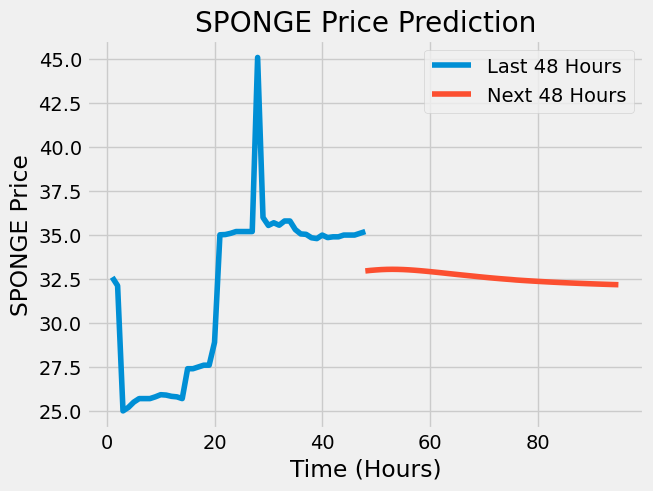

In [15]:
x_input = scaled_data[-prediction_hours:]
temp_input = list(x_input)

model_output = []

for i in range(48):  
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, -1)

    prediction = model.predict(x_input, verbose=0) 
    prediction = prediction.flatten() 

    temp_input.append(prediction[0])
    if len(temp_input) > prediction_hours:
        temp_input = temp_input[1:]
    model_output.append(prediction[0]) 



# plot the future 48 hours
day_new = np.arange(1, prediction_hours + 1)
day_pred = np.arange(prediction_hours, prediction_hours + 48)

prev_data = scaled_data[-prediction_hours:]
prev_data = prev_data.reshape(-1, 1)
prev_data = scaler.inverse_transform(prev_data) 

plt.plot(day_new, prev_data.flatten(), label="Last 48 Hours")
plt.plot(day_pred, scaler.inverse_transform(np.array(model_output).reshape(-1, 1)).flatten(), label="Next 48 Hours")
plt.title(f"{item} Price Prediction")
plt.xlabel("Time (Hours)")
plt.ylabel(f"{item} Price")
plt.legend()
plt.show()

(1556, 8)


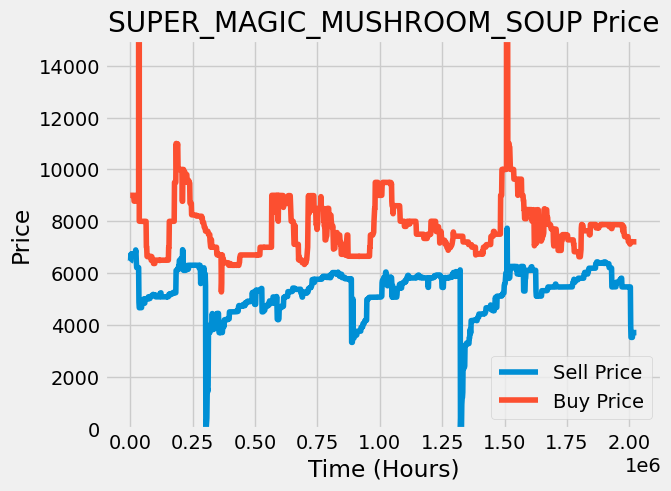

In [16]:
# plot SUPER_MAGIC_MUSHROOM_SOUP

smms = data_set[data_set['item'] == "SUPER_MAGIC_MUSHROOM_SOUP"]
print(smms.shape)

# only keep sell_price and buy_price
smms = smms[['date','sell_price', 'buy_price']] 


plt.plot(smms['sell_price'], label="Sell Price")
plt.plot(smms['buy_price'], label="Buy Price")
plt.ylim(0,15000) 
plt.title("SUPER_MAGIC_MUSHROOM_SOUP Price")
plt.xlabel("Time (Hours)")
plt.ylabel("Price")
plt.legend()
plt.show()


dict_values([8999.6, 8999.3, 8999.36, 9000.0, 8999.99, 8999.9, 8999.3, 8999.19, 8999.2, 8999.0, 8999.1, 8998.7, 8773.0, 8772.8, 8772.7, 8772.6, 8772.69, 8999.08, 8999.3, 9000.0, 8999.66, 8999.9, 8999.4, 8998.8, 8998.4, 8997.7, 8996.78, 4656561.4, 7999.6, 7999.0, 7998.8, 7997.7, 7997.6, 7997.68, 7997.4, 7997.4, 7997.4, 7997.2, 7997.2, 7994.98, 7995.0, 7997.3, 7997.3, 7997.2, 7997.16, 7996.4, 7995.5, 7994.8, 7995.44, 7994.83, 6999.95, 6999.83, 6648.3, 6632.67, 6648.2, 6648.25, 6647.98, 6647.9, 6647.85, 6648.0, 6648.0, 6648.1, 6648.3, 6648.2, 6647.68, 6492.49, 6492.52, 6625.89, 6499.2, 6499.0, 6466.51, 6498.9, 6369.0, 6369.0, 6367.08, 6369.0, 6369.06, 6498.9, 6498.8, 6498.0, 6497.9, 6497.61, 6496.79, 6497.0, 6497.0, 6497.61, 6497.83, 6497.9, 6497.8, 6497.8, 6497.4, 6482.38, 6497.2, 6496.94, 6496.57, 6496.58, 6496.5, 6496.04, 6495.49, 6495.05, 6495.79, 6495.79, 6495.1, 6496.5, 6496.4, 6496.3, 6496.28, 6495.8, 6495.8, 6495.88, 6495.87, 6495.9, 6496.08, 6496.39, 6496.5, 6496.6, 6496.5, 6496.

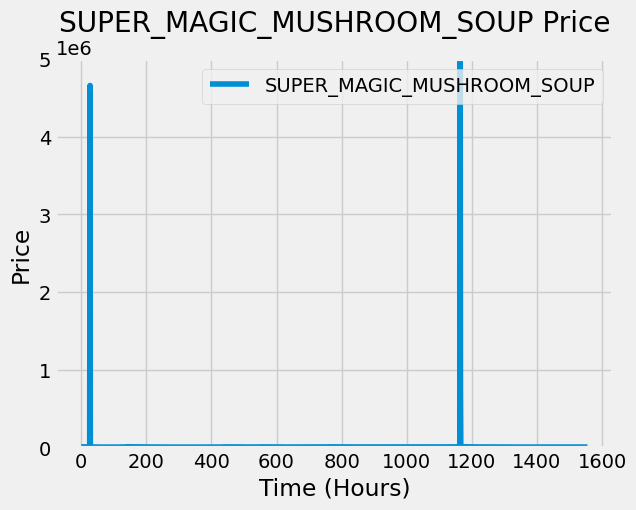

In [30]:
 
dictval = {}

for row in smms.iterrows():
    index, data = row
    dictval[data['date']] = round(data['buy_price'], 2) 

print(dictval.values())

print(max(dictval.values()))

print(np.average(list(dictval.values())))

plt.plot(dictval.values(), label="SUPER_MAGIC_MUSHROOM_SOUP")  

# get 99th percentile
percentile = np.percentile(list(dictval.values()), 99)

print(percentile)


plt.title("SUPER_MAGIC_MUSHROOM_SOUP Price")

plt.ylim(0,5000000)
plt.xlabel("Time (Hours)")
plt.ylabel("Price")
plt.legend() 
plt.show()